In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

In [2]:
path_image = "/kaggle/input/human-faces-object-detection/images"
path_b_box_image = "/kaggle/input/human-faces-object-detection/faces.csv"

In [3]:
images = os.listdir(path_image)
df_bounding_box = pd.read_csv(path_b_box_image)
print("Sampel Gambar : ", images[0:6])
print("Sampel box :\n", df_bounding_box.head(3))


Sampel Gambar :  ['00002129.jpg', '00001760.jpg', '00001158.jpg', '00001981.jpg', '00000503.jpg', '00001965.jpg']
Sampel box :
      image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331


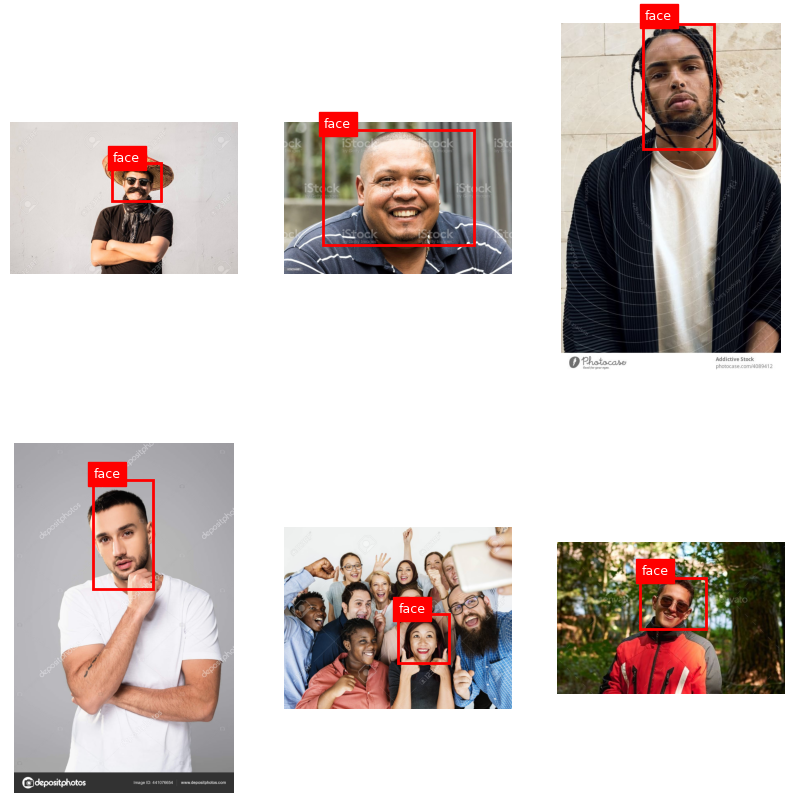

In [4]:
# testing image
fig, axs = plt.subplots(2, 3, figsize=(10,10))

for ax, image in zip(axs.ravel(), images[0:6]):
    b_box = df_bounding_box.query("image_name == '{}'".format(image))
    x0, y0, x1, y1 = [b_box.x0.iloc[0], b_box.y0.iloc[0], b_box.x1.iloc[0], b_box.y1.iloc[0]]
    rect = patches.Rectangle((int(x0), int(y0)), int(x1-x0), int(y1-y0), linewidth=2, edgecolor='r', facecolor='none' )
    img = cv2.imread(os.path.join(path_image, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.add_patch(rect)
    ax.text(x0+4, y0-10, "face", color='white', fontsize=9, backgroundcolor='red')
    ax.axis("off")
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

In [5]:
os.makedirs("labels_penampungan", exist_ok=True)
os.makedirs("trains_penampungan", exist_ok=True)

In [6]:
# mengubah bounding box ke format yolo
def format_bounding_box(row):
    dw = 1./row['width']
    dh = 1./row['height']
    x = (row['x0'] + row['x1']) / 2.0
    y = (row['y0'] + row['y1']) / 2.0
    w = (row['x1'] - row['x0'])
    h = (row['y1'] - row['y0'])
    return [x*dw, y*dh, w*dw, h*dh]

In [7]:
# menambahkan fitur baru
df_bounding_box[['x_center', 'y_center', 'bbox_width', 'bbox_height']] = df_bounding_box.apply(format_bounding_box, axis=1, result_type="expand")
df_bounding_box['class_id'] = 0
df_bounding_box.head(3)

,image_name,width,height,x0,y0,x1,y1,x_center,y_center,bbox_width,bbox_height,class_id
0,00001722.jpg,1333,2000,490,320,687,664,0.441485,0.246000,0.147787,0.172000,0
1,00001044.jpg,2000,1333,791,119,1200,436,0.497750,0.208177,0.204500,0.237809,0
2,00001050.jpg,667,1000,304,155,407,331,0.532984,0.243000,0.154423,0.176000,0


In [8]:
for idx, row in df_bounding_box.iterrows():
    filename = row['image_name'].replace('.jpg','.txt')
    with open(f'/kaggle/working/labels_penampungan/{filename}', 'w') as f:
        f.write(f"{row['class_id']} {row['x_center']} {row['y_center']} {row['bbox_width']} {row['bbox_height']}")

In [9]:
import random
import shutil
images_path = '/kaggle/input/human-faces-object-detection/images'
labels_path = '/kaggle/working/labels_penampungan'

train_images_path = 'images/train'
valid_images_path = 'images/valid'

train_labels_path = 'labels/train'
valid_labels_path = 'labels/valid'

os.makedirs(train_images_path, exist_ok=True)
os.makedirs(valid_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(valid_labels_path, exist_ok=True)

In [10]:
# melakukan pembagian gambar
all_images = os.listdir(images_path)
all_labels = os.listdir(labels_path)

random.seed(42)
random.shuffle(all_images)

split_ratio=0.8
split_idx = int(split_ratio * len(all_images))

print(all_images[0:3])
print(all_labels[0:3])

['00001570.jpg', '00000127.jpg', '00002380.jpg']
['00001696.txt', '00001665.txt', '00000579.txt']


In [11]:
train_files = all_images[:split_idx]
valid_files = all_images[split_idx:]
def copy_image(files, src_path, dst_path):
    for file in files:
        src = os.path.join(src_path, file)
        dst = os.path.join(dst_path, file)
        shutil.copy(src, dst)

copy_image(train_files, images_path, train_images_path)
copy_image([f.replace('.jpg', '.txt') for f in train_files], labels_path, train_labels_path)
copy_image(valid_files, images_path, valid_images_path)
copy_image([f.replace('.jpg', '.txt') for f in valid_files], labels_path, valid_labels_path)

In [12]:
train_tes = os.listdir('/kaggle/working/images/train')[2]
train_label = os.listdir('/kaggle/working/labels/train')
print(train_tes)
print('00002325.txt' in train_label)

00001001.jpg
True


In [13]:
!pip install ultralytics pyyaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 14.1 MB/s eta 0:00:00a 0:00:01


In [14]:
from ultralytics import YOLO
model = YOLO('yolov10n.pt')
model.info()

100%|██████████| 5.59M/5.59M [00:00<00:00, 67.0MB/s]


YOLOv10n summary: 385 layers, 2,775,520 parameters, 0 gradients, 8.7 GFLOPs


(385, 2775520, 0, 8.7404288)

In [15]:
import yaml
data = {
    'train': '/kaggle/working/images/train',
    'val': '/kaggle/working/images/valid',
    'nc': 1,
    'names': ['Face']
}

with open('/kaggle/working/mydataset.yaml', 'w') as file:
    yaml.dump(data, file, sort_keys=False)

In [16]:
result_trains = model.train(
    data="mydataset.yaml",
    epochs=10,
    imgsz=640
)

Ultralytics YOLOv8.2.57 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=mydataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]
2024-07-15 07:04:07,266	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-15 07:04:08,061	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 1763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1763/1763 [00:01<00:00, 1220.40it/s]


train: New cache created: /kaggle/working/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/labels/valid... 441 images, 0 backgrounds, 0 corrupt: 100%|██████████| 441/441 [00:00<00:00, 1170.96it/s]

val: New cache created: /kaggle/working/labels/valid.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.13G      3.142       13.8      3.782          3        640: 100%|██████████| 111/111 [00:28<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

                   all        441        441      0.438      0.281      0.289      0.099



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.11G      2.951      8.125      3.479          3        640: 100%|██████████| 111/111 [00:26<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.20it/s]


                   all        441        441      0.381      0.442      0.357      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.12G       2.89      5.197      3.452          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.16it/s]


                   all        441        441      0.362      0.349      0.308      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.12G      2.905      3.789      3.448          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.16it/s]

                   all        441        441      0.423      0.542      0.415      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.12G      2.737      3.078      3.272          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.16it/s]


                   all        441        441      0.519      0.667      0.589      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.11G      2.632      2.671      3.197          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        441        441      0.474      0.592      0.494      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.12G      2.488      2.454        3.1          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]

                   all        441        441      0.542      0.647      0.617      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.12G      2.374      2.203      2.969          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.12it/s]

                   all        441        441      0.463      0.599      0.479      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.12G      2.261      2.025      2.884          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]

                   all        441        441      0.582       0.58      0.542      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.11G      2.156      1.892      2.759          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.18it/s]

                   all        441        441      0.606      0.678      0.653       0.35



10 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.57 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.50it/s]


                   all        441        441      0.607      0.678      0.653       0.35
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆█▇▆▅▄▃▂▁
lr/pg1,▃▆█▇▆▅▄▃▂▁
lr/pg2,▃▆█▇▆▅▄▃▂▁
metrics/mAP50(B),▁▂▁▃▇▅▇▅▆█
metrics/mAP50-95(B),▁▂▂▄▆▄█▄▅█
metrics/precision(B),▃▂▁▃▅▄▆▄▇█
metrics/recall(B),▁▄▂▆█▆▇▇▆█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▆▅▄▃▃▂▁


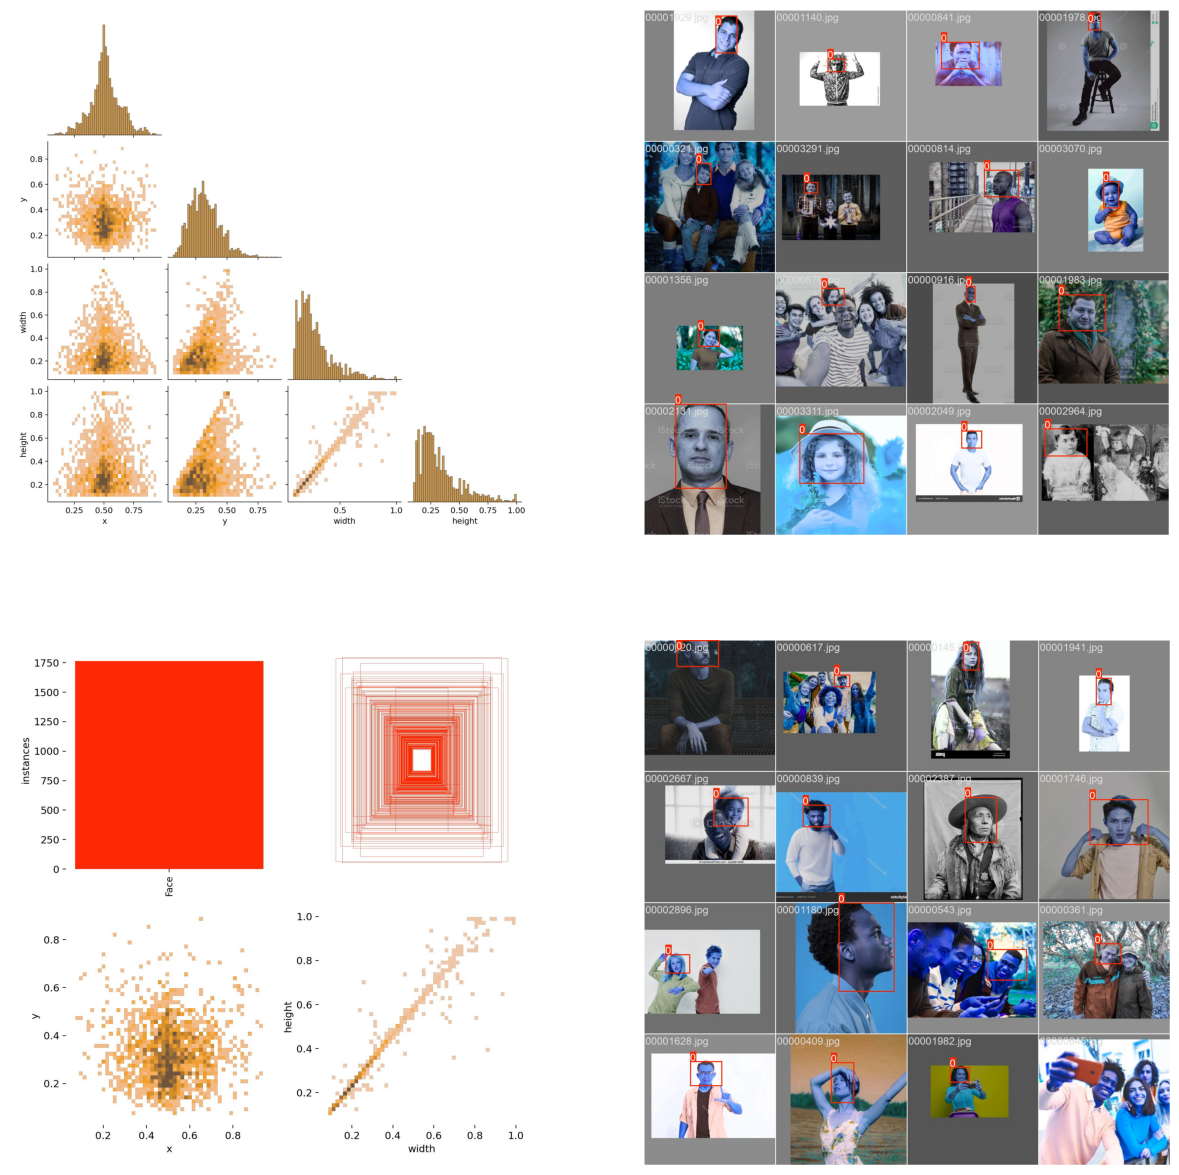

In [22]:
# evaluasi model
fig, axs = plt.subplots(2,2, figsize=(15,15))
img1 = cv2.imread('/kaggle/working/runs/detect/train/labels_correlogram.jpg')
img2 = cv2.imread('/kaggle/working/runs/detect/train/train_batch1.jpg')
img3 = cv2.imread('/kaggle/working/runs/detect/train/labels.jpg')
img4 = cv2.imread('/kaggle/working/runs/detect/train/train_batch0.jpg')
axs[0,0].imshow(img1)
axs[0,0].axis('off')

axs[0,1].imshow(img2)
axs[0,1].axis('off')

axs[1,0].imshow(img3)
axs[1,0].axis('off')

axs[1,1].imshow(img4)
axs[1,1].axis('off')
plt.show()

In [23]:
result_data = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
result_data

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.1419,13.8040,3.7823,0.43763,0.28118,0.28889,0.09902,2.8936,12.3270,3.5958,0.000661,0.000661,0.000661
1,2,2.9512,8.1251,3.4794,0.38061,0.44171,0.35736,0.15232,3.1359,5.4722,3.8600,0.001196,0.001196,0.001196
2,3,2.8896,5.1973,3.4523,0.36151,0.34921,0.30827,0.13726,3.1104,4.7281,3.7710,0.001599,0.001599,0.001599
3,4,2.9051,3.7895,3.4477,0.42340,0.54195,0.41461,0.19393,2.8746,3.7440,3.4444,0.001406,0.001406,0.001406
4,5,2.7370,3.0783,3.2724,0.51908,0.66667,0.58882,0.29529,2.9735,2.8258,3.5510,0.001208,0.001208,0.001208
5,6,2.6317,2.6711,3.1967,0.47438,0.59184,0.49358,0.20079,3.0012,3.4715,3.9493,0.001010,0.001010,0.001010
6,7,2.4878,2.4541,3.1002,0.54213,0.64704,0.61661,0.34270,2.5736,2.5785,3.1429,0.000812,0.000812,0.000812
7,8,2.3736,2.2032,2.9691,0.46279,0.59864,0.47862,0.22174,2.7793,3.2426,3.3433,0.000614,0.000614,0.000614
8,9,2.2612,2.0255,2.8844,0.58222,0.58050,0.54209,0.23229,3.1216,3.1452,4.1549,0.000416,0.000416,0.000416
9,10,2.1563,1.8925,2.7591,0.60606,0.67800,0.65297,0.35013,2.5854,2.6471,3.1261,0.000218,0.000218,0.000218
